# Loan Approval Classification: Model Tuning, Selection & Evaluation

**Project:** Data Science/ML Practice  
**Objective:** Compare, tune, and evaluate two tree-based classification models (Random Forest and Gradient Boosting) for loan approval prediction. Save the best-performing model for deployment.

## 1. Load and Prepare Data

Load the cleaned data from Notebook 1. Identify numeric and categorical features. Set up the target variable.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Load cleaned data
data = pd.read_csv('data/loanApproval/cleanLoanApprovalData.csv')

# Set target and features
target_col = 'loan_status'
X = data.drop(columns=target_col)
y = data[target_col].astype(int)  # Convert bool to int for sklearn compatibility

# Identify feature types
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()
numeric_features = X.select_dtypes(include=[np.number, 'bool']).columns.tolist()

print(f"Categorical features: {categorical_features}")
print(f"Numeric features: {numeric_features}")

Categorical features: ['person_gender', 'person_education', 'person_home_ownership', 'loan_intent', 'previous_loan_defaults_on_file']
Numeric features: ['person_age', 'person_income', 'person_emp_exp', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length', 'credit_score']


## 2. Train/Test Split & Cross-Validation Strategy

### Train/Test Split (80/20)
- **Purpose**: Keep 20% of data completely unseen during training to get honest performance estimates
- **Stratified Split**: Maintains the same proportion of approved/rejected loans in both train and test sets

### Cross-Validation Strategy
- **5-Fold Stratified CV**: Splits training data into 5 parts, trains on 4, validates on 1, repeats 5 times
- **Stratified**: Each fold maintains the original class distribution (loan approval ratios)

**Correct Flow**: 
1. **Split**: Full Data → Train Data (80%) + Test Data (20%)
2. **Tune**: Train Data → GridSearchCV with 5-Fold CV → Best Parameters
3. **Train**: Best Parameters + **Full Train Data** → Final Model 
4. **Evaluate**: Final Model → Test Data → Final Performance Metrics



In [2]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
print(f"Train size: {X_train.shape[0]}, Test size: {X_test.shape[0]}")

# Stratified cross-validation for imbalanced data
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

Train size: 36000, Test size: 9000


## 3. Preprocessing Pipeline
One-hot encode categoricals. No scaling required for tree models.

In [3]:
# Preprocessing for tree models: only one-hot encoding for categoricals
categorical_transformer = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])
preprocessor = ColumnTransformer(transformers=[
    ('cat', categorical_transformer, categorical_features)
], remainder='passthrough')

## 4. Model Pipelines and Hyperparameter Grids
Define comprehensive hyperparameter grids based on data characteristics and model.

### Hyperparameter Strategy:
- **Random Forest**: Focus on tree depth, feature sampling, and ensemble size
- **Gradient Boosting**: Tune learning rate, regularization, and tree complexity
- **Data-Driven Ranges**: Based on feature count (~{len(X.columns)}) and sample size (~{len(X)})

In [4]:
# Hyperparameter grids based on data characteristics
n_features = X.shape[1]
n_samples = X.shape[0]

print(f"Dataset: {n_samples} samples, {n_features} features")
print(f"Class distribution: {y.value_counts().to_dict()}")

# Simple feature-driven min_samples_split range (2 to n_features-1)
min_samples_split_range = list(range(2, n_features))
print(f"min_samples_split range: {min_samples_split_range}")

models = {
    "RandomForest": {
        "estimator": Pipeline([
            ("preprocessor", preprocessor),
            ("classifier", RandomForestClassifier(random_state=42, class_weight='balanced', n_jobs=-1))
        ]),
        # Comprehensive grid based on data size and features
        "param_grid": {
            "classifier__n_estimators": [100, 200, 300],  # More trees for better performance
           # "classifier__max_depth": [10, 15, 20, None],  # Control overfitting
            "classifier__max_features": ["sqrt", "log2", 0.3],  # Feature sampling strategies
           # "classifier__min_samples_split": min_samples_split_range,  # 2 to n_features-1
            "classifier__min_samples_split": [2, 3, 5, 8],
           # "classifier__min_samples_leaf": [1, 2, 4],    # Leaf node regularization
        },
        "results": {}
    },
    "GradientBoosting": {
        "estimator": Pipeline([
            ("preprocessor", preprocessor),
            ("classifier", GradientBoostingClassifier(random_state=42))
        ]),
        # Learning rate and regularization focused
        "param_grid": {
            "classifier__n_estimators": [100, 200, 300],
           # "classifier__learning_rate": [0.05, 0.1, 0.15],  # Critical for GB performance
           # "classifier__max_depth": [3, 5, 7],              # Shallow trees for GB
            "classifier__max_features": ["sqrt", "log2"],
            #"classifier__min_samples_split": min_samples_split_range,  # 2 to n_features-1
            "classifier__min_samples_split": [2, 3, 5, 8],
           # "classifier__subsample": [0.8, 0.9, 1.0],        # Stochastic gradient boosting
        },
        "results": {}
    }
}


Dataset: 45000 samples, 13 features
Class distribution: {0: 35000, 1: 10000}
min_samples_split range: [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


## 5. Model Training, Tuning, Evaluation
Train models with cross-validation, tune parameters, and evaluate.

In [5]:
def train_and_evaluate(model_name, model_dict, X_train, X_test, y_train, y_test, categorical_features, cv):
    """
    Train and evaluate a model, storing metrics and best params.
    
    Parameters:
    -----------
    model_name : str
        Name of the model for display purposes
    model_dict : dict
        Dictionary containing model estimator and parameter grid
    X_train, X_test : pandas.DataFrame
        Training and test feature sets
    y_train, y_test : pandas.Series
        Training and test target variables
    categorical_features : list
        List of categorical feature column names
    cv : sklearn cross-validation object
        Cross-validation strategy (e.g., StratifiedKFold)
    Returns:
    --------
    dict : Updated model dictionary with results
    
    Raises:
    -------
    ValueError: If model training fails
    """
    try:
        print(f"\n==== {model_name} ====")
        grid = GridSearchCV(
            model_dict["estimator"], 
            model_dict["param_grid"], 
            cv=cv, 
            scoring="roc_auc", 
            n_jobs=-1, 
            return_train_score=True,
            verbose=1 # Add progress tracking
        )
        
        grid.fit(X_train, y_train)
        
        # Store grid and best results
        model_dict["grid"] = grid
        model_dict["results"]["best_params"] = grid.best_params_
        model_dict["results"]["best_cv_auc"] = grid.best_score_

        print("Best params:", grid.best_params_)
        print("Best CV ROC-AUC:", grid.best_score_)
        
        # Test set evaluation
        try:
            y_pred = grid.predict(X_test)
            y_proba = grid.predict_proba(X_test)[:,1]

            model_dict["results"]["test_auc"] = roc_auc_score(y_test, y_proba)
            model_dict["results"]["test_accuracy"] = accuracy_score(y_test, y_pred)
            model_dict["results"]["test_precision"] = precision_score(y_test, y_pred)
            model_dict["results"]["test_recall"] = recall_score(y_test, y_pred)
            model_dict["results"]["test_f1"] = f1_score(y_test, y_pred)
            model_dict["results"]["confusion_matrix"] = confusion_matrix(y_test, y_pred)
        
            # print("Test set AUC:", model_dict["results"]["test_auc"])
            print(f"✓ Test AUC: {model_dict['results']['test_auc']:.4f}")

            # Cross-validated AUCs for visualization
            model_dict["results"]["cv_aucs"] = cross_val_score(grid.best_estimator_, X_train, y_train, cv=cv, scoring="roc_auc")
            print("Cross-validated AUCs:", model_dict["results"]["cv_aucs"])

        except Exception as e:
            print(f"✗ Error in test evaluation: {str(e)}")
            raise ValueError(f"Test evaluation failed: {str(e)}")    

    except Exception as e:
        print(f"✗ Error training {model_name}: {str(e)}")
        model_dict["results"]["error"] = str(e)
    
    return model_dict

## 6. Train and Evaluate Both Models

In [6]:
for name in models:
    train_and_evaluate(
        name,
        models[name],
        X_train,
        X_test,
        y_train,
        y_test,
        categorical_features,
        cv  # Pass the cv object as parameter
    )


==== RandomForest ====
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best params: {'classifier__max_features': 0.3, 'classifier__min_samples_split': 3, 'classifier__n_estimators': 300}
Best CV ROC-AUC: 0.974212310267857
✓ Test AUC: 0.9761
Cross-validated AUCs: [0.97384805 0.97091445 0.97670179 0.97378359 0.97581367]

==== GradientBoosting ====
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best params: {'classifier__max_features': 'sqrt', 'classifier__min_samples_split': 3, 'classifier__n_estimators': 300}
Best CV ROC-AUC: 0.9733897098214286
✓ Test AUC: 0.9745
Cross-validated AUCs: [0.97297924 0.96954531 0.97507946 0.97399018 0.97535435]


## 7. Model Comparison: Visualize ROC and CV AUCs

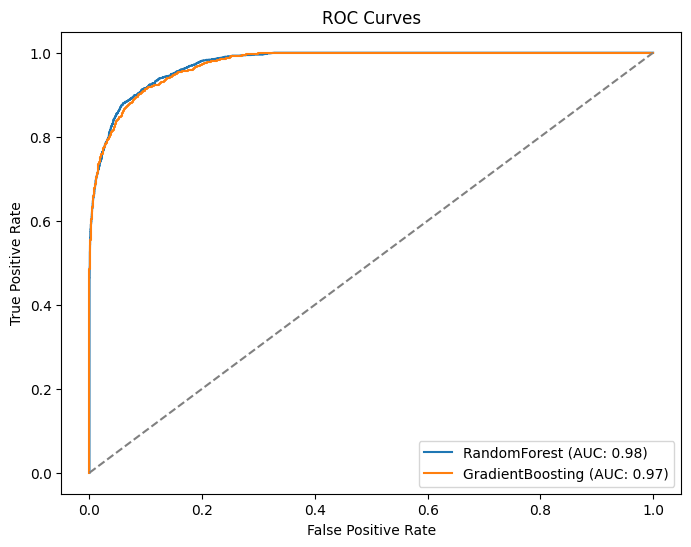

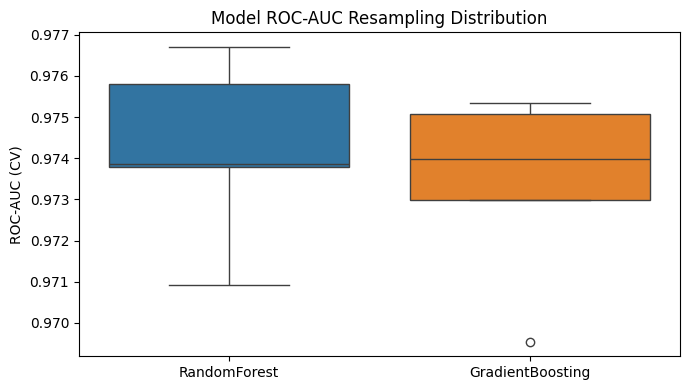


Cross-Validation Stability: RandomForest
CV ROC-AUC: 0.9742 ± 0.0020
CV Standard Deviation: 0.0020
✓ Model is stable (CV std < 0.02)

Cross-Validation Stability: GradientBoosting
CV ROC-AUC: 0.9734 ± 0.0021
CV Standard Deviation: 0.0021
✓ Model is stable (CV std < 0.02)


In [7]:
# ROC curves for both models
plt.figure(figsize=(8,6))
for name, model in models.items():
    grid = model["grid"]
    y_proba = grid.predict_proba(X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc = roc_auc_score(y_test, y_proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC: {auc:.2f})")
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend()
plt.show()

# Boxplot of CV AUCs
cv_auc_dict = {name: model["results"]["cv_aucs"] for name, model in models.items() if "cv_aucs" in model["results"]}
cv_auc_df = pd.DataFrame(cv_auc_dict)
plt.figure(figsize=(7,4))
sns.boxplot(data=cv_auc_df)
plt.ylabel("ROC-AUC (CV)")
plt.title("Model ROC-AUC Resampling Distribution")
plt.tight_layout()
plt.show()

# Calculate and display CV metric stability (standard deviation)
for name, model in models.items():
    if "results" in model and "cv_aucs" in model["results"]:
        cv_aucs = model["results"]["cv_aucs"]
        cv_std = np.std(cv_aucs)
        cv_mean = np.mean(cv_aucs)

        print(f"\n{'='*50}")
        print(f"Cross-Validation Stability: {name}")
        print(f"{'='*50}")
        print(f"CV ROC-AUC: {cv_mean:.4f} ± {cv_std:.4f}")
        print(f"CV Standard Deviation: {cv_std:.4f}")
                    
        if cv_std < 0.02:
            print("✓ Model is stable (CV std < 0.02)")
        else:
            print("! Model stability could be improved (CV std ≥ 0.02)")

In [8]:
def analyze_feature_importance(model_dict: dict, feature_names: list, top_n: int = 15):
    """
    Analyze and visualize feature importance.
    
    Parameters:
    -----------
    model_dict : dict
        Trained model dictionary
    feature_names : list
        List of all feature names
    top_n : int
        Number of top features to display
    """
    try:
        if "grid" not in model_dict or model_dict["grid"] is None:
            print("No trained model found")
            return
        
        classifier = model_dict["grid"].best_estimator_.named_steps['classifier']
        
        if hasattr(classifier, 'feature_importances_'):
            importances = classifier.feature_importances_
            
            # Create importance DataFrame
            importance_df = pd.DataFrame({
                'feature': feature_names,
                'importance': importances
            }).sort_values('importance', ascending=False)
            
            # Store results
            model_dict["results"]["feature_importance"] = importance_df
            
            # Visualization
            plt.figure(figsize=(10, 8))
            top_features = importance_df.head(top_n)
            sns.barplot(data=top_features, x='importance', y='feature', palette='viridis')
            plt.title(f'Top {top_n} Feature Importances')
            plt.xlabel('Importance Score')
            plt.tight_layout()
            plt.show()
            
        # Extract and display normalized feature importance as percentages
        # print(f"Top {min(top_n, len(importance_df))} Features:")
        # print(importance_df.head(top_n))

        if "results" in models[model_name] and "feature_importance" in models[model_name]["results"]:
            print(f"\n{'='*50}")
            print(f"Normalized Top {top_n} Feature Importance (Percentages): {model_name}")
            print(f"{'='*50}")
        
            # Get feature importance and normalize to percentages
            importance_df = models[model_name]["results"]["feature_importance"].copy()
            importance_df['importance_pct'] = importance_df['importance'] * 100
            
            # Display top 10 features with percentage values
            top_features = importance_df.head(top_n)
            print(top_features[['feature', 'importance', 'importance_pct']])
            print("\nTop 3 predictors:")
            for i, row in top_features.head(3).iterrows():
                print(f"- {row['feature']}: {row['importance']:.2f} ({row['importance_pct']:.1f}%)")

            
    except Exception as e:
        print(f"Error analyzing feature importance: {str(e)}")


Feature Importance Analysis: RandomForest


C:\Users\ashu\AppData\Local\Temp\ipykernel_27276\4180011053.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_features, x='importance', y='feature', palette='viridis')


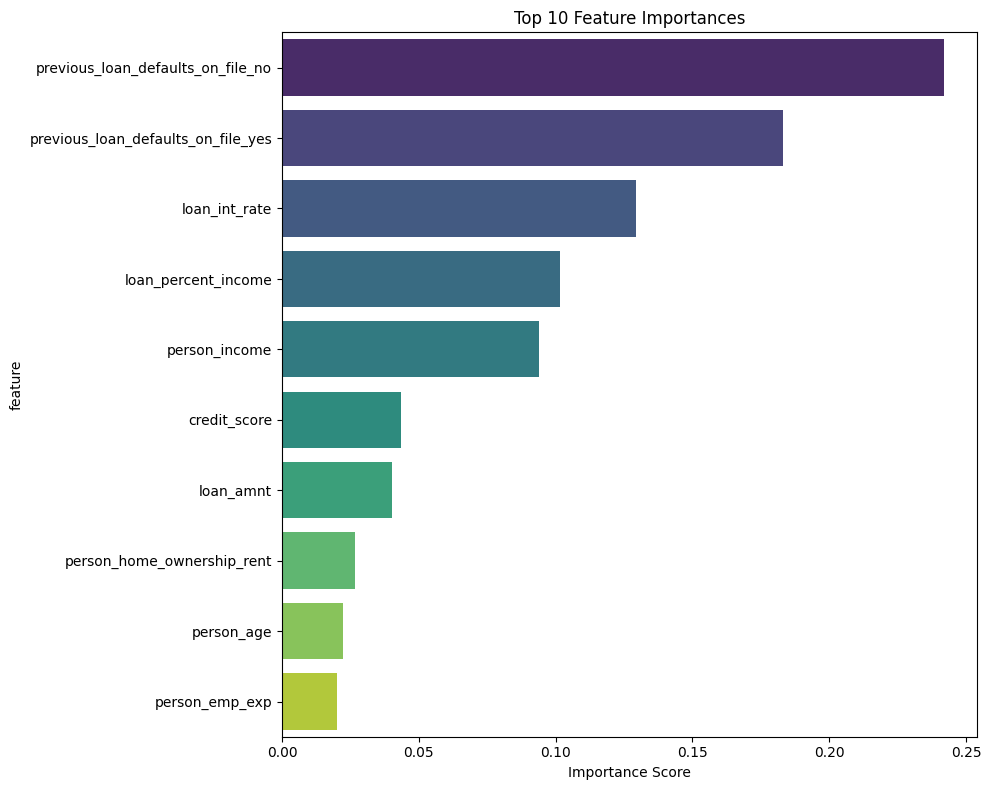

C:\Users\ashu\AppData\Local\Temp\ipykernel_27276\4180011053.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_features, x='importance', y='feature', palette='viridis')



Normalized Top 10 Feature Importance (Percentages): RandomForest
                               feature  importance  importance_pct
17   previous_loan_defaults_on_file_no    0.241922       24.192154
18  previous_loan_defaults_on_file_yes    0.183014       18.301438
23                       loan_int_rate    0.129537       12.953735
24                 loan_percent_income    0.101556       10.155617
20                       person_income    0.094107        9.410700
26                        credit_score    0.043503        4.350276
22                           loan_amnt    0.040291        4.029110
10          person_home_ownership_rent    0.026760        2.675993
19                          person_age    0.022153        2.215287
21                      person_emp_exp    0.020021        2.002141

Top 3 predictors:
- previous_loan_defaults_on_file_no: 0.24 (24.2%)
- previous_loan_defaults_on_file_yes: 0.18 (18.3%)
- loan_int_rate: 0.13 (13.0%)

Feature Importance Analysis: GradientBoosting


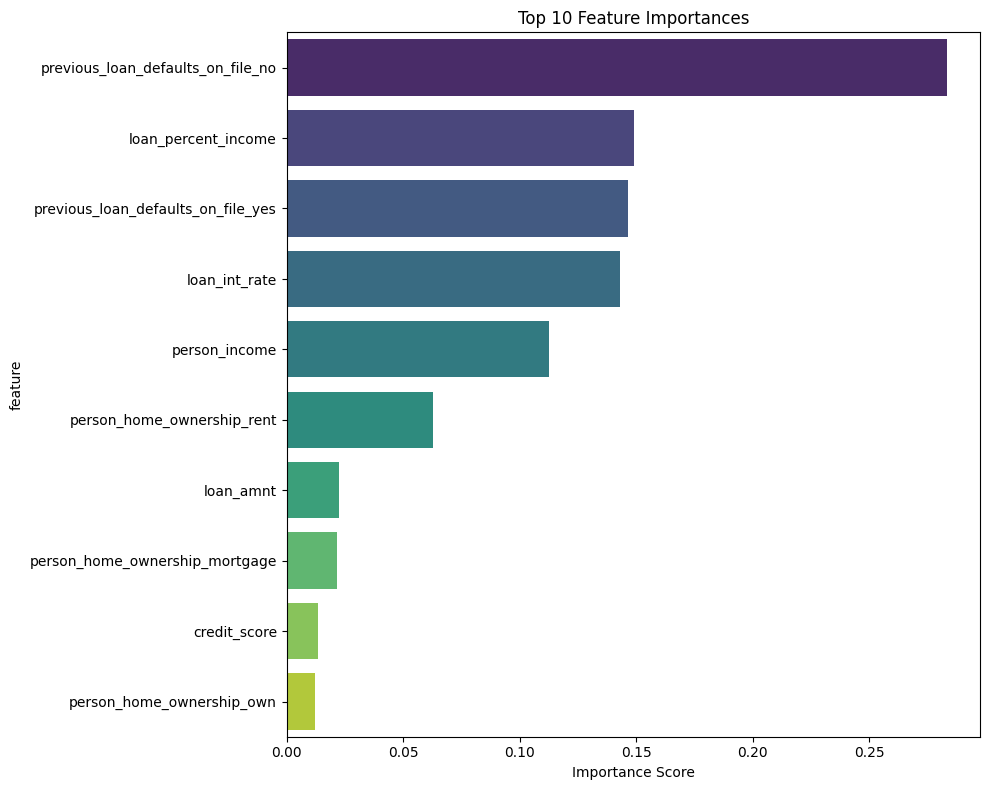


Normalized Top 10 Feature Importance (Percentages): GradientBoosting
                               feature  importance  importance_pct
17   previous_loan_defaults_on_file_no    0.283345       28.334465
24                 loan_percent_income    0.148983       14.898310
18  previous_loan_defaults_on_file_yes    0.146271       14.627111
23                       loan_int_rate    0.142854       14.285352
20                       person_income    0.112603       11.260265
10          person_home_ownership_rent    0.062762        6.276182
22                           loan_amnt    0.022537        2.253732
7       person_home_ownership_mortgage    0.021550        2.154962
26                        credit_score    0.013598        1.359801
9            person_home_ownership_own    0.012188        1.218841

Top 3 predictors:
- previous_loan_defaults_on_file_no: 0.28 (28.3%)
- loan_percent_income: 0.15 (14.9%)
- previous_loan_defaults_on_file_yes: 0.15 (14.6%)


In [9]:
# Get feature names after preprocessing
# Extract categorical feature names from one-hot encoder
ohe_features = models[name]["grid"].best_estimator_.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)
all_feature_names = list(ohe_features) + numeric_features

# Analyze feature importance for both models
# Extract and display normalized feature importance as percentages
for model_name in models:

    if "grid" in models[model_name] and models[model_name]["grid"] is not None:
        print(f"\n{'='*50}")
        print(f"Feature Importance Analysis: {model_name}")
        print(f"{'='*50}")
        analyze_feature_importance(models[model_name], all_feature_names, top_n=10)
# Save the best model (Random Forest) for deployment

## 8. Summary Table: Model Metrics

In [10]:
metrics = []
for name, model in models.items():
    r = model["results"]
    metrics.append({
        "Model": name,
        "Test AUC": r["test_auc"],
        "Accuracy": r["test_accuracy"],
        "Precision": r["test_precision"],
        "Recall": r["test_recall"],
        "F1": r["test_f1"]
    })
summary = pd.DataFrame(metrics)
print("\nModel Performance Metrics:\n", summary)


Model Performance Metrics:
               Model  Test AUC  Accuracy  Precision  Recall        F1
0      RandomForest  0.976127  0.929333   0.892405  0.7755  0.829856
1  GradientBoosting  0.974492  0.929444   0.889333  0.7795  0.830802


## 9. Save the Best Model
Select and save the best-performing model (highest ROC-AUC).

In [11]:
# Select best model by test ROC-AUC
best_model_name = summary.sort_values(by='Test AUC', ascending=False).iloc[0]['Model']
best_pipeline = models[best_model_name]["grid"].best_estimator_
model_path = f'model/loanApproval/Loan_{best_model_name}_model.pkl'
joblib.dump(best_pipeline, model_path)
print(f"Best model ({best_model_name}) saved to {model_path}")

Best model (RandomForest) saved to model/loanApproval/Loan_RandomForest_model.pkl


In [12]:
# Save train and test data with output variable for model monitoring baseline
train_baseline = X_train.copy()
train_baseline[target_col] = y_train
test_baseline = X_test.copy()
test_baseline[target_col] = y_test
train_baseline.to_csv('data/loanApproval/LoanData_train_baseline.csv', index=False)
test_baseline.to_csv('data/loanApproval/LoanData_test_baseline.csv', index=False)
print('Train and test baseline data saved for model monitoring.')

Train and test baseline data saved for model monitoring.


## Conclusion
- Both Random Forest and Gradient Boosting models were trained, tuned and evaluated.
- The best-performing model Random Forest(by ROC-AUC) was saved for deployment.
- Feature importance and evaluation metrics can be reviewed above.

### Next Steps
- Deploy the saved model to Hugging Face or another serving platform as needed.
- Use modular code and templates for future ML projects.